In [24]:
# Packages
using CSV
using DifferentialEquations
using DiffEqParamEstim
using Optim
using LinearAlgebra
using Plots
using Plots.PlotMeasures
using LaTeXStrings
using NLsolve
pyplot();

In [25]:
df=CSV.read("realdata.csv")
#load If, It, Twc
df_input = df[70:653, [:Column6, :Column13, :Column11 ]]
df_output = df[70:653, [:Column7, :Column8]]
df_water_temp = df[70:653, [:Column10, :Column9]]
If_s, It_s, Twc_s = df_input[1],df_input[2],df_input[3]
Ts_meas_s, TFe_meas_s = df_output[1], df_output[2]
Tac_s, Tah_s = df_water_temp[1],df_water_temp[2]
# All data are vectors of strings and missing, so converting
# it back to float64
#
# N measurement data are used
N = 584
If,It,Twc,Ts_m,TFe_m =zeros(N),zeros(N),zeros(N),zeros(N),zeros(N)
Tac_m, Tah_m = zeros(N), zeros(N)
for i in range(1,step=1,N)
    If[i]=parse(Float64, If_s[i])
    It[i]=parse(Float64, It_s[i])
    Twc[i]=parse(Float64, Twc_s[i])
    Ts_m[i]=parse(Float64, Ts_meas_s[i])
    TFe_m[i]=parse(Float64, TFe_meas_s[i])
    Tac_m[i]=parse(Float64, Tac_s[i])
    Tah_m[i]=parse(Float64, Tah_s[i])
end


In [26]:
# Available data of states for defining loss function
data = [Ts_m TFe_m]'

2×584 Adjoint{Float64,Array{Float64,2}}:
 31.4186  32.3701  32.9818  34.4092  …  68.8184  68.8184  68.8184  68.8184
 32.3701  32.3701  32.3701  32.3701     60.3393  60.3393  60.3393  60.3393

In [27]:
# Inputs function given from data each at 60 sec
function u_If(t)
    # Iterative value of Ifd from real data
    # taken at 60 seconds
    t=trunc(Int,t/60+1)
    return If[t]
end
function u_It(t)
    # Iterative value of It from real data
    t=trunc(Int,t/60+1)
    return It[t]
end
function u_Twc(t)
    # Iterative value of Twc from real data
    t=trunc(Int,t/60+1)
    return Twc[t]
end

u_Twc (generic function with 1 method)

In [28]:
# Model 1
function gen(dx,x,p,t)
    # unpacking states
    Tr,Ts,TFe = x
    # Default parameters
    mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,
        71200., 0.127e-3,1.95e-6 ,2.7,20,14.3,55.6,222., 212.,528., 53.9, 49.2
    # Normalized parameters values
    Nmr,Nms,NmFe,NRr,NRs,NUAr2d,NUAs2Fe,NUAFe2a,NhAax,NhAwx,NQdFes,NWdf,Nmda,Nmdw = p
    # inputs
    If = u_If(t)
    It = u_It(t)
    Twc = u_Twc(t)
    # constants specific heat capacities
    chpa,chpw,chpCu,chpFe = 1.012,4.1813,0.385,0.412 
    # Auxiliary parameters
    UAx = 1/(1/(NhAax*hAax)+1/(NhAwx*hAwx))
    Qdfs = 0.8*(NWdf*Wdf)
    # Stanton numbers
    NSta = UAx/chpa/(Nmda*mda)
    NStw = UAx/chpw/(Nmdw*mdw)
    NStd = NStw - NSta
    # Matrices
    M1 = diagm(0=>[(Nmr*mr)*chpCu , (Nms*ms)*chpCu , (NmFe*mFe)*chpFe])
    M2 = [-(NUAr2d*UAr2d) 0. 0.; 0. -(NUAs2Fe*UAs2Fe) (NUAs2Fe*UAs2Fe); 0. (NUAs2Fe*UAs2Fe) -(NUAs2Fe*UAs2Fe)-(NUAFe2a*UAFe2a)]
    M3 = [0. (UAr2d) 0.; 0. 0. 0.; 0. 0. (UAFe2a)]
    #
    N1 = [-(Nmda*mda)*chpa (Nmda*mda)*chpa+(NUAr2d*UAr2d) 0.; 0. -(Nmda*mda)*chpa (Nmda*mda)*chpa+(NUAFe2a*UAFe2a); NStw-NSta*exp(-NStd) 0. -NStd]
    N2 = [(NUAr2d*UAr2d) 0. 0.; 0. 0. (NUAFe2a*UAFe2a); 0. 0. 0.]
    #
    v = [1.1*(Rr)*If^2, 3*(Rs)*It^2, (NQdFes*QdFes)]
    w = [Qdfs, 0., NSta*(1-exp(-NStd))*Twc]
    #
    z = N1\(N2*x + w)
    dxdt = M1\(M2*x+M3*z + v)
    dx[1],dx[2],dx[3]=dxdt
end
# Parameters
# p = [mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
p = [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.] 
# Initial values
x0 = [28.,Ts_m[1],TFe_m[1]]
# Time span
tspan = (0, 583*60.)
# Defining ODE problem
prob = ODEProblem(gen,x0,tspan,p)
sol = solve(prob, ABM54(), dt=60);

In [23]:
Sol = reduce(hcat,sol.u)
[Sol[2,:]'; Sol[3,:]']

2×584 Array{Float64,2}:
 31.4186  33.0167  34.1129  34.8891  …  64.3094  64.3015  64.2925  64.283 
 32.3701  32.5372  32.7486  32.9855     57.9529  57.9451  57.9374  57.9297

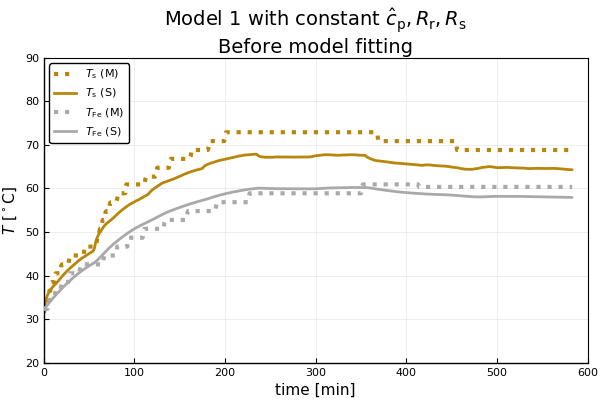

In [40]:
plot(sol.t/60,Ts_m,label=L"T_\mathrm{s}\ \mathrm{(M)}",lc=:darkgoldenrod,lw=3,ls=:dot)
plot!(sol.t/60,sol[2,:], label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
Model1Ts=plot!(xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,600),framestyle = :box)

plot!(sol.t/60,TFe_m,label=L"T_\mathrm{Fe}\ \mathrm{(M)}",lc=:darkgrey,lw=3,ls=:dot )
plot!(sol.t/60,sol[3,:], label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
Model1TFe=plot!(xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,600),framestyle = :box)

Model1beforeFitting=plot!(title=string("Model 1 with constant ", "\$\\hatc_\\mathrm{p},R_\\mathrm{r},R_\\mathrm{s}\$\nBefore model fitting"),
    xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,600),ylim=(20,90),framestyle = :box,legend=:topleft)


In [52]:
dt = 60.
p = [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
low_p = -10*p
high_p = 10*p
# custom cost_function
function cost(p,gen_r,x0_r,tspan_r,dt_r,data_r)
    prob = ODEProblem(gen_r,x0_r,tspan_r,p)
    sol = solve(prob, saveat=dt_r)
    Sol = reduce(hcat,sol.u)
    sim = [Sol[2,:]'; Sol[3,:]']
    return norm(sim-data_r,2)^2/length(sim)
end

cost (generic function with 1 method)

In [53]:
# Initial value of loss function
loss = (p) -> cost(p,gen,x0,tspan,dt,data)

#11 (generic function with 1 method)

In [54]:
res = optimize(loss,low_p,high_p,p,Fminbox(GradientDescent()))

Results of Optimization Algorithm
 * Algorithm: Fminbox with Gradient Descent
 * Starting Point: [1.0,1.0, ...]
 * Minimizer: [1.002429091165187,1.0590227988192504, ...]
 * Minimum: 2.949704e+00
 * Iterations: 2
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 2.27e+01 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 253
 * Gradient Calls: 253

In [55]:
res.minimizer

14-element Array{Float64,1}:
 1.002429091165187 
 1.0590227988192504
 1.007905502837838 
 0.9996446196064285
 0.9996446196064285
 0.9968223765136704
 0.7382753445810938
 0.9825806587027833
 0.9967294578921034
 0.9973752608554   
 1.0010289519536457
 1.001306999384261 
 0.9971691494909052
 0.9975433397832719

In [56]:
# setting optimized parameter
p = res.minimizer
prob = ODEProblem(gen,x0,tspan,p)
# solution after optimized parameters
sol_after = solve(prob, ABM54(), dt=60);

In [57]:
sol-sol_after

3×584 Array{Float64,2}:
 0.0  -0.00327771  -0.00667413  …  -0.459525  -0.459501  -0.459482
 0.0   0.0859633    0.0144615      -3.74857   -3.74744   -3.74645 
 0.0  -0.0150051   -0.017415       -1.48963   -1.48957   -1.48949 

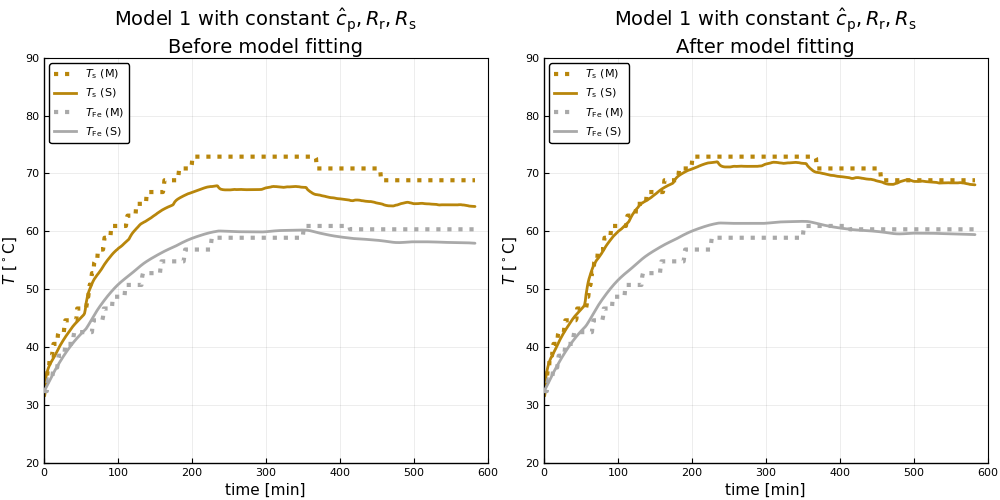

In [58]:
# Plotting after opitmized parameters
plot(sol_after.t/60,Ts_m,label=L"T_\mathrm{s}\ \mathrm{(M)}",lc=:darkgoldenrod,lw=3,ls=:dot)
plot!(sol_after.t/60,sol_after[2,:], label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
Model1Ts=plot!(xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,600),framestyle = :box)

plot!(sol_after.t/60,TFe_m,label=L"T_\mathrm{Fe}\ \mathrm{(M)}",lc=:darkgrey,lw=3,ls=:dot )
plot!(sol_after.t/60,sol_after[3,:], label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
Model1TFe=plot!(xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,600),framestyle = :box)

Model1afterFitting=plot!(title=string("Model 1 with constant ", "\$\\hatc_\\mathrm{p},R_\\mathrm{r},R_\\mathrm{s}\$\nAfter model fitting"),
    xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,600),ylim=(20,90),framestyle = :box,legend=:topleft)
plot(Model1beforeFitting,Model1afterFitting,layout=grid(1,2),size = (1000, 500))